# The Gaussian Distribution 
Univariate gaussian is 
$$\mathcal{N}\left(x | \mu, \sigma^{2}\right)=\frac{1}{\left(2 \pi \sigma^{2}\right)^{1 / 2}} \exp \left\{-\frac{1}{2 \sigma^{2}}(x-\mu)^{2}\right\}$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as Norm

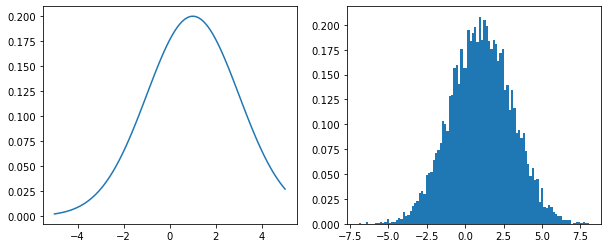

In [2]:
loc, scale = 1, 2
x = np.linspace(-5, 5, 100)
norm = Norm(loc, scale)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x, norm.pdf(x))
plt.subplot(1, 2, 2)
res = plt.hist(norm.rvs(10000), bins=100, density=True)

### 2.3.4 Maximum Likelihood for the Gaussian

The likelihood function of Gaussian is 
$$L\left(\mu, \sigma^{2} ; x_{1}, \ldots, x_{N}\right)=\prod_{i=1}^N\frac{1}{\left(2 \pi \sigma^{2}\right)^{1 / 2}} \exp \left\{-\frac{1}{2 \sigma^{2}}(x_i-\mu)^{2}\right\} = \left(2 \pi \sigma^{2}\right)^{-\frac{N}{2}} \exp \left(-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{n}\left(x_{i}-\mu\right)^{2}\right)$$
The log-likelihood function is 
$$l\left(\mu, \sigma^{2} ; x_{1}, \ldots, x_{n}\right)=-\frac{N}{2} \ln (2 \pi)-\frac{N}{2} \ln \left(\sigma^{2}\right)-\frac{1}{2 \sigma^{2}} \sum_{j=1}^{N}\left(x_{j}-\mu\right)^{2}$$
The MLE for $\mu$ and $\sigma^2$ is 
\begin{align*}
    \mu &= \frac{1}{N}\sum_{n=1}^{N}x_{n}\\
    \sigma^{2}&=\frac{1}{N} \sum_{n=1}^{N}\left(x_{n}-\mu\right)^{2}
\end{align*}

### 2.3.4 Prior for the Gaussian
#### 2.3.4.1 Fixed $\sigma^2$ random $\mu$
Keeping $\sigma^2$ fixed, the conjugate prior for $\mu$ is a Gaussian $\mathcal{N}\left(\mu_{0}, \sigma_{0}^{2}\right)$, then the posterior
$$\mu | x \sim \mathcal{N}\left(\frac{\sigma_{0}^{2}}{\sigma^{2}+\sigma_{0}^{2}} x+\frac{\sigma^{2}}{\sigma^{2}+\sigma_{0}^{2}} \mu_{0},\left(\frac{1}{\sigma_{0}^{2}}+\frac{1}{\sigma^{2}}\right)^{-1}\right)$$
From the above we know that if $\sigma^2$ is big, then new $x$ has lesser effect on the posterior $\mu$, but will make posterior $\sigma^2$ larger. To see more clearly
$$\operatorname{Var}(\mu | x)=\frac{\sigma^{2} \sigma_{0}^{2}}{\sigma^{2}+\sigma_{0}^{2}}=\frac{1}{\frac{1}{\sigma_{0}^{2}}+\frac{1}{\sigma^{2}}}$$
If $\sigma^2\to \infty$, then $\mu\to \mu_0$ and $\sigma^2\to \sigma_0^2$

In [8]:
real_mu, real_std = 3, 2
data = Norm(real_mu, real_std).rvs(1000)
x_ = np.linspace(-1, 5, 500)

0.00, 1.00
3.19, 0.14
3.04, 0.10
3.00, 0.08
3.02, 0.07


Text(0.5, 1.0, 'As more data been observed, the std of mu will goes smaller.')

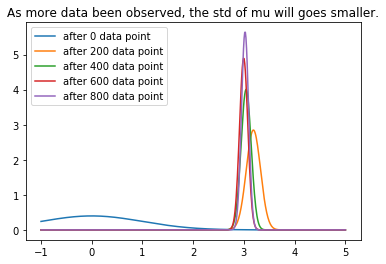

In [9]:
pos_mu, pos_std = 0, 1
for i, x in enumerate(data):
    if i % 200 == 0:
        norm = Norm(pos_mu, pos_std)
        plt.plot(x_, Norm(pos_mu, pos_std).pdf(x_), label=f"after {i} data point")
        print(f"{pos_mu:.2f}, {pos_std:.2f}")
    denom = real_std**2+pos_std**2
    pos_mu = pos_std**2/denom * x + real_std**2/denom * pos_mu
    pos_std = np.sqrt(1/(1/pos_std**2 + 1/real_std**2))
plt.legend()
plt.title("As more data been observed, the std of mu will goes smaller.")

Consider the data batch of size $n$
$$\mu | x_{1}, x_{2}, \cdots, x_{n} \sim \mathcal{N}\left(\frac{\sigma_{0}^{2}}{\frac{\sigma^{2}}{n}+\sigma_{0}^{2}} \bar{x}+\frac{\frac{\sigma^{2}}{n}}{\frac{\sigma^{2}}{n}+\sigma_{0}^{2}} \mu_{0},\left(\frac{1}{\sigma_{0}^{2}}+\frac{n}{\sigma^{2}}\right)^{-1}\right)$$
Suppose $n$ is big and $\sigma^2$ is small, then 
$$\mu | x_{1}, x_{2}, \cdots, x_{n} \sim \mathcal{N}\left(\bar{x},0\right)$$

0.00, 1.00
3.19, 0.14
3.04, 0.10
3.00, 0.08
3.02, 0.07


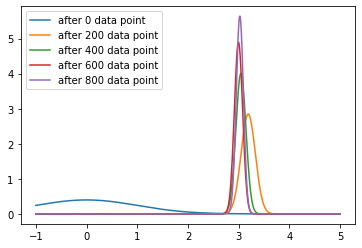

In [10]:
# Batch
pos_mu, pos_std = 0, 1
n = 200
for i in range(0, data.shape[0], n):
    norm = Norm(pos_mu, pos_std)
    plt.plot(x_, Norm(pos_mu, pos_std).pdf(x_), label=f"after {i} data point")
    print(f"{pos_mu:.2f}, {pos_std:.2f}")
    sub = data[i:i+n]
    denom = real_std**2/n + pos_std**2
    pos_mu = pos_std**2/denom * sub.mean() + real_std**2/n/denom * pos_mu
    pos_std = np.sqrt(1/(1/pos_std**2 + n/real_std**2))
plt.legend()

In [23]:
import pyro
import torch
import pyro.distributions as dist
import torch.distributions.constraints as constraints

from pyro.optim import Adam
from pyro.infer import Trace_ELBO, SVI

In [33]:
# model is always prior and likelihood
def model(data, real_std=2.):
    mu = pyro.sample("latent_mean", dist.Normal(2.0, 2.0))
    with pyro.plate("observed"):
        pyro.sample("obs", dist.Normal(mu, real_std), obs=data)

def guide(data):
    mean = pyro.param("mean_q", 10.0)
    std = pyro.param("std_q", 2.0, constraint=constraints.positive)
    pyro.sample("latent_mean", dist.Normal(mean, std))

In [34]:
data = torch.from_numpy(data).float()
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 10000
# do gradient steps
for step in range(n_steps): svi.step(data)

In [35]:
mean_q = pyro.param('mean_q').item()
std_q = pyro.param('std_q').item()
print(mean_q, std_q)

2.9893293380737305 0.06406991928815842


#### 2.3.4.2 Fixed $\mu$ random $\sigma^2$
Assuming $\mu$ is fixed, then the conjugate prior for $\sigma^2$ is an inverse Gamma distribution $\mathrm{IG}(\alpha, \beta)$,
$$P(z | \alpha, \beta)=\frac{\beta^{\alpha}}{\Gamma(\alpha)} z^{-\alpha-1} \exp \left(-\frac{\beta}{z}\right)$$
then the posterior is 
$$\sigma^{2} | x_{1}, x_{2}, \cdots, x_{n} \sim \operatorname{IG}\left(\alpha+\frac{n}{2}, \beta+\frac{1}{2} \sum\left(x_{i}-\mu\right)\right)$$

In [36]:
from scipy.stats import invgamma

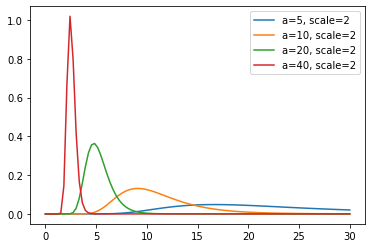

In [38]:
x = np.linspace(0, 30, 100)
# a controls the shape
for a in [5, 10, 20, 40]:
    y = invgamma(a, scale=100).pdf(x)
    plt.plot(x, y, label=f"a={a}, scale={scale}")
plt.legend()

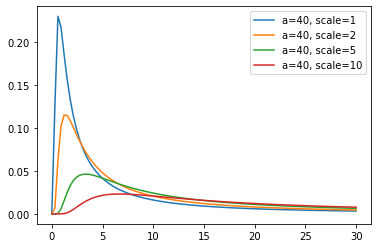

In [43]:
for scale in [1, 2, 5, 10]:
    y = invgamma(a=0.5, scale=scale).pdf(x)
    plt.plot(x, y, label=f"a={a}, scale={scale}")
plt.legend()

For prediction
\begin{aligned} P\left(x_{\text { new }} | x, \mu, \alpha, \beta\right) &=\int P\left(x_{\text { new }} | x, \mu, \tau, \alpha, \beta\right) P(\tau | x, \alpha, \beta) d \tau \\ &=\int P\left(x_{\text { new }} | \mu, \tau\right) P(\tau | x, \alpha, \beta) d \tau \\ &=\int P\left(x_{\text { new }} | \mu, \tau\right) P\left(\tau | \alpha_{\text { post }}, \beta_{\text { post }}\right) d \tau, \end{aligned}
where $\tau=1/\sigma^2$ is the precision. This integral will is the **student-t distribution**
$$P(x | \mu, \alpha, \beta)==\frac{\Gamma\left(\alpha+\frac{1}{2}\right)}{\Gamma(\alpha)} \frac{1}{(2 \pi \beta)^{\frac{1}{2}}} \frac{1}{\left(1+\frac{1}{2 \beta}(x-\mu)^{2}\right)^{\alpha+\frac{1}{2}}}$$
The pdf is symmetric around $\mu$. Let $p=2\alpha, \lambda = \alpha/\beta$, we have
$$P(x | \mu, p, \lambda)=\frac{\Gamma\left(\frac{p+1}{2}\right)}{\Gamma\left(\frac{p}{2}\right)}\left(\frac{\lambda}{\pi p}\right)^{\frac{1}{2}} \frac{1}{\left(1+\frac{\lambda}{p}(x-\mu)^{2}\right)^{\frac{p+1}{2}}}$$
The t distribution (aka, Student’s t-distribution) is a probability distribution that is used to estimate population parameters when the sample size is small and/or when the population variance is unknown.

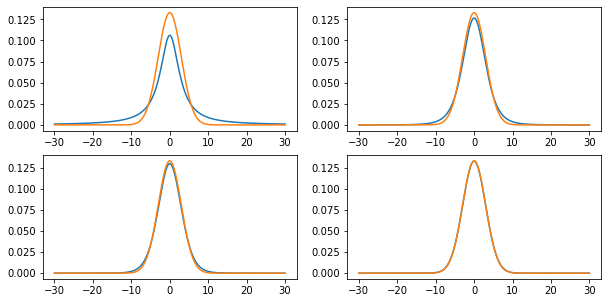

In [46]:
from scipy.stats import t
x = np.linspace(-30, 30, 500)
y1 = Norm(loc=0, scale=3).pdf(x)
plt.figure(figsize=(10, 5))
# As the degree of freedom increase, t close to normal.
for i, df in enumerate([1, 5, 10, 100]):
    plt.subplot(2, 2, i+1)
    y = t(loc=0, df=df, scale=3).pdf(x)
    plt.plot(x, y)
    plt.plot(x, y1)

#### 2.3.4.3 Random $\mu$ random $\sigma^2$

We will use the following prior distribution which, as we will show, is conjugate to the Gaussian likelihood:
\begin{aligned} x_{i} | \mu, \tau & \sim \mathcal{N}(\mu, \tau) \quad \text { i.i.d. } \\ \mu | \tau & \sim \mathcal{N}\left(\mu_{0}, n_{0} \tau\right) \\ \tau & \sim \operatorname{Ga}(\alpha, \beta) \end{aligned}
Then the posterior is 
\begin{aligned} \mu | \tau, x & \sim \mathcal{N}\left(\frac{n \tau}{n \tau+n_{0} \tau} \overline{x}+\frac{n_{0} \tau}{n \tau+n_{0} \tau} \mu_{0} \quad, \quad n \tau+n_{0} \tau\right) \\ \tau | x & \sim \operatorname{Ga}\left(\alpha+\frac{n}{2} \quad, \quad \beta+\frac{1}{2} \sum\left(x_{i}-\overline{x}\right)^{2}+\frac{n n_{0}}{2\left(n+n_{0}\right)}\left(\overline{x}-\mu_{0}\right)^{2}\right) \end{aligned}
For prediction, student t

### 2.3 The Multivariate Gaussian Distribution 

The pdf for multivariate gaussian is 
$$p(X | \mu, \Sigma)=\frac{1}{(2 \pi)^{p / 2}} \frac{1}{\sqrt{|\Sigma|}} \exp \left(-\frac{1}{2}(X-\mu)^{T} \Sigma^{-1}(X-\mu)\right)$$
1. For case of fixed variance, the conjugate prior is a multivariate gaussian of mean $\mu_0$ and covariance matrix $\Sigma_0$.
2. later

In [ ]:
from scipy.stats import multivariate_normal as nm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# the input matrix must be positive semidefinite
model = nm(mean=[2., 2.], cov=[[1., 0.3], [0.3, 1.]])
xs, ys = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
xy = np.stack([xs, ys]).reshape(2, -1).T
z = model.pdf(xy).reshape(xs.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xs,ys, z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

### 2.3.6 Bayesian inference for the Gaussian

In [ ]:
from scipy.stats import norm

In [ ]:
mu = norm(0, 0.1)
model = norm(mu.rvs(), 0.1)
x = np.linspace(-1, 1, 100)

plt.plot(x, model.pdf(x), label="N=0")

mu, std = norm.fit(np.random.normal(loc=0.8, scale=0.1, size=1))
plt.plot(x, norm(mu, std).pdf(x), label="N=1")

mu, std = norm.fit(np.random.normal(loc=0.8, scale=0.1, size=4))
plt.plot(x, norm(mu, std).pdf(x), label="N=4")

mu, std = norm.fit(np.random.normal(loc=0.8, scale=0.1, size=10))
plt.plot(x, norm(mu, std).pdf(x), label="N=10")

plt.xlim(-1, 1)
plt.ylim(0, 10)
plt.legend()
plt.show()

### 2.3.9 Mixture of Gaussians

In [ ]:
x1 = np.random.normal(size=(100, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(100, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(100, 2))
x3 += np.array([0, 5])
X = np.vstack((x1, x2, x3))

model = MultivariateGaussianMixture(n_components=3)
model.fit(X)
print(model)

x_test, y_test = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
X_test = np.array([x_test, y_test]).reshape(2, -1).transpose()
probs = model.pdf(X_test)
Probs = probs.reshape(100, 100)
plt.scatter(X[:, 0], X[:, 1])
plt.contour(x_test, y_test, Probs)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()